In [1]:
import numpy as np
import pandas as pd
import csv
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
dataset_path = './data/gtzan'
diraudiofiles = f"{dataset_path}/genres_3sec"
features_path = f'{dataset_path}/features'
melspec_path = f'{features_path}/melspecs_3sec'
test_dir = f'{dataset_path}/test1'

In [4]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [5]:
target_size = (288, 432)
# target_size = (640,480)
batch_size = 128

In [6]:
import keras.backend as K

In [7]:
def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

In [21]:
model = tf.keras.models.load_model("models/model_tv20", custom_objects={'get_f1': get_f1})

In [22]:
import pickle

In [23]:
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

In [24]:
def plot_history(hist):
    fig,ax = plt.subplots(2, 1, figsize=(8,5))
    # fig.tight_layout()

    ax[0].plot(hist['accuracy'])
    ax[0].plot(hist['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'val'], loc='upper left')

    plt.subplots_adjust(hspace = 0.4)

    ax[1].plot(hist['loss'])
    ax[1].plot(hist['val_loss'])
    plt.title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    plt.show()

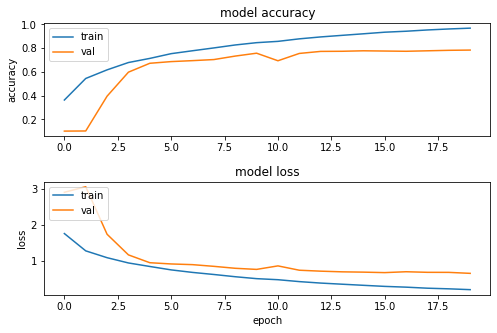

In [25]:
plot_history(hist)

In [26]:
def predict(model, image_data, target_size, classes):
    #image = image_data.resize((288,432))
    image = img_to_array(image_data)
    image = np.reshape(image,(1,*target_size,4))
    image /= 255
    prediction = model.predict(image)
    prediction = prediction.reshape((classes,))
    class_label = np.argmax(prediction)

    return class_label,prediction

In [27]:
test_dir = f'{dataset_path}/test'
filename = 'metal/metal.00362.png'

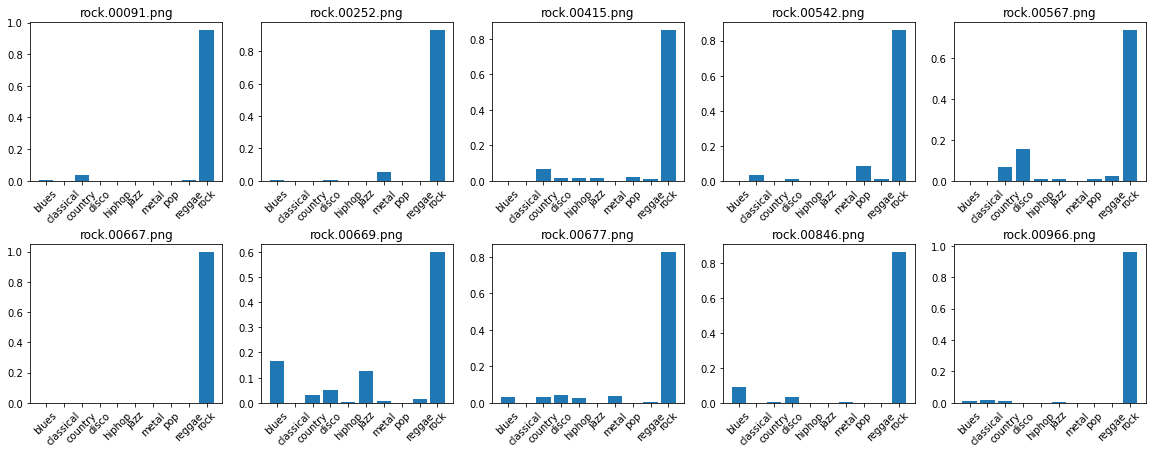

In [28]:
test_dir = f'{dataset_path}/test'
g = 'rock'

fig,ax = plt.subplots(2,5,figsize=(20,7))

for i, filename in enumerate(os.listdir(f'{test_dir}/{g}')):
    _r = i // 5
    _c = i % 5
    
    image_data = load_img(f'{test_dir}/{g}/{filename}',color_mode='rgba',target_size=target_size)
    class_label, prediction = predict(model, image_data, target_size, 10)
    
    ax[_r][_c].bar(x=genres,height=prediction)
    ax[_r][_c].tick_params('x', labelrotation=45)
    ax[_r][_c].set_title(f'{filename}')
    plt.subplots_adjust(hspace = 0.4)


plt.show()

In [33]:
test_dir = f'{dataset_path}/test1'
song = 'Taylor_Swift_Love_Story'
song += ' Muse_Plug_In_Baby'
song += ' Nirvana_Smells_Like_Teen_Spirit'
song += ' Green_Day_American_Idiot'
songs = song.split()

preds = None

for song in songs:
    pred = None
    for i, filename in enumerate(os.listdir(f'{test_dir}')):
        if song not in filename:
            continue
        image_data = load_img(f'{test_dir}/{filename}',color_mode='rgba',target_size=target_size)
        class_label, prediction = predict(model, image_data, target_size, 10)
        if pred is None:
            pred = prediction
        else:
            pred = (pred + prediction)

    if preds is None:
        preds = pred / np.sum(pred)
    else:
        preds = np.vstack([preds, pred / np.sum(pred)])

In [30]:
preds.shape

(4, 10)

In [31]:
np.sum(preds,axis=1)

array([1.        , 1.        , 0.99999994, 1.        ], dtype=float32)

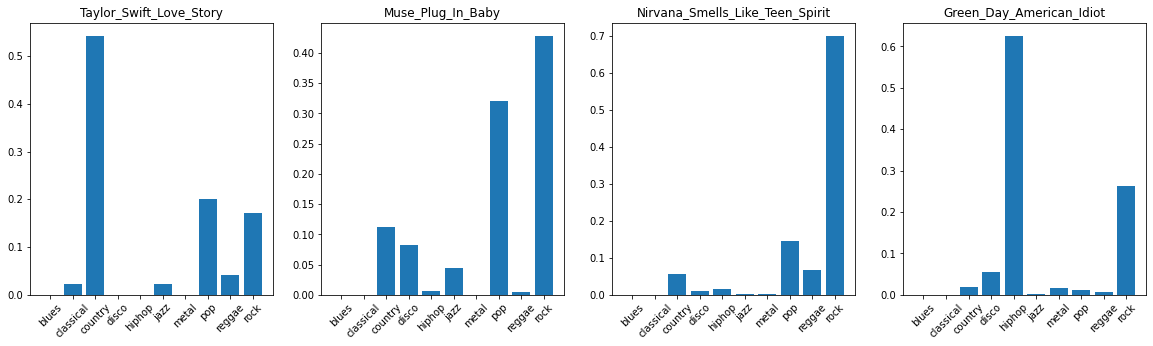

In [34]:
fig,ax = plt.subplots(1,4,figsize=(20,5))

for i in range(4):
    ax[i].bar(x=genres,height=preds[i])
    ax[i].tick_params('x', labelrotation=45)
    ax[i].set_title(f'{songs[i]}')
    
plt.show()